In [1]:
import numpy as np
from math import*
#import matplotlib.pyplot 
import matplotlib.pyplot as plt
import random
import scipy
import scipy.stats
from Projet.HTBandits import ParetoBandit
#from scipy.optimize import NonlinearConstraint
plt.rcParams["figure.figsize"] = (8,8)

Exploration au sujet de la loi de Pareto.

la fonction de densité d'une variable de Pareto est 

$$f(x;x_m,k)=\left\{
\begin{array}{ll}
\dfrac{kx_m^k}{x^{k+1}} & \text{si $x\geq x_m$}\\
0                       & \text{sinon}
\end{array}
\right.
$$

où $x_m>0$ et $k>0.$

Si $k\leq1,$ la loi ne possède pas d'espérance (moyenne théorique), en fait l'espérance est infinie.

On considère pour commencer le cas $k=1,$ voici quelques de distributions de la famille de Pareto avec $k=1$ et différentes valeurs de $x_m.$


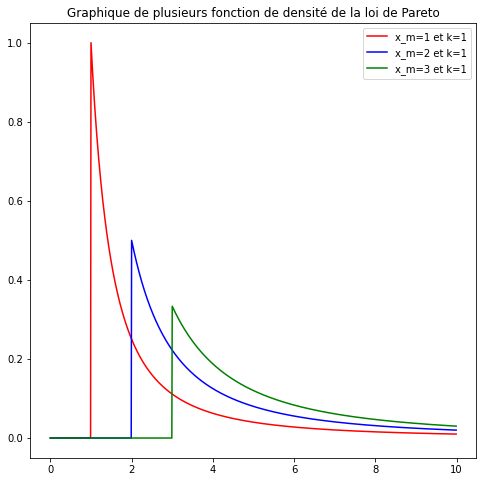

In [2]:
x=np.arange(0,10,0.01)

k=1
x_m_1=1
x_m_2=2
x_m_3=3

#pareto.pdf(x=samples, b=1, loc=0, scale=x_m)

y1=scipy.stats.pareto.pdf(x, b=k, loc=0, scale=x_m_1)
y2=scipy.stats.pareto.pdf(x, b=k, loc=0, scale=x_m_2)
y3=scipy.stats.pareto.pdf(x, b=k, loc=0, scale=x_m_3)
#y3=scipy.stats.cauchy.pdf(x, loc=4, scale=3)

plt.plot(x,y1,color='red', label='x_m={} et k={}'.format(x_m_1,k))
plt.plot(x,y2,color='blue', label='x_m={} et k={}'.format(x_m_2,k))
plt.plot(x,y3,color='green', label='x_m={} et k={}'.format(x_m_3,k))

plt.title('Graphique de plusieurs fonction de densité de la loi de Pareto')
plt.legend()

Remarque, la loi de Pareto possède une médiane de $2^{1/k} x_m,$ notamment pour le cas qui nous intéresse ($k=1$), la médiane est $2\,x_m.$

In [3]:
#Vérification de la correct définition de Scipy, comparaison avec les valeurs de Maple pour certains points
print(scipy.stats.pareto.pdf(1.4, b=k, loc=0, scale=x_m_1))
print(scipy.stats.pareto.pdf(4.5, b=k, loc=0, scale=x_m_2))

0.5102040816326531
0.09876543209876543


Illustration du fait que l'espérance est infinie.

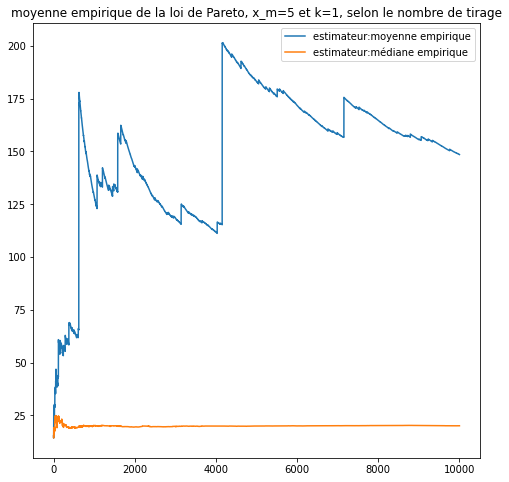

In [4]:
T=10000
k=1
x_m=10

X=[]
moyenne_empirique=np.zeros(T,dtype=np.float32)
mediane_empirique=np.zeros(T,dtype=np.float32)

for i in range(T):
    X.append(scipy.stats.pareto.rvs(b=1, loc=0, scale=x_m,size=1))
    moyenne_empirique[i]=np.mean(X)
    mediane_empirique[i]=np.median(X)
    
plt.plot(range(T),moyenne_empirique,label='estimateur:moyenne empirique')
plt.plot(range(T),mediane_empirique,label='estimateur:médiane empirique')
plt.title('moyenne empirique de la loi de Pareto, x_m=5 et k=1, selon le nombre de tirage')
plt.legend()

In [5]:
##Petit test pour montrer que la classe ParetoBandit semble fonctionner.
bandittest=ParetoBandit(x_m=np.array([1,4]),k=np.array([1,1]),seed=1)
r=np.zeros(100)
for i in range(100):
    if i%2==0:
        r[i]=bandittest.play(0)
    else:
        r[i]=bandittest.play(1)
        
print(r)

print(bandittest.gaps)
    

[  1.71533061  14.30228928   1.00011439   5.73339079   1.17199754
   4.4069297    1.22889407   6.11210263   1.65773555   8.67334159
   1.72174682  12.70726746   1.25699557  32.81847609   1.02815879
  12.13840857   1.71616311   9.0639198    1.16331411   4.9881624
   5.01868377 126.03020127   1.45650337  13.00063054   8.08990488
  37.95306357   1.09294898   4.1625682    1.20457317  32.82522711
   1.10907391   6.90974726  23.74706346   8.56834308   3.24545837
   5.84381497   3.1898021   24.18755103   1.01862897  16.00924149
  89.77538214  15.883457     1.38974588  18.98247557   1.11510816
   7.24497935  10.94038077   5.66262757   1.40405135   4.59785215
   1.01974944  12.45467793   1.26843691   5.44622753   1.96685131
   4.2254825    2.34806607   4.6878401    2.43490013  13.32260242
   1.11400062   6.8265908    3.272253     6.8280274    1.05258001
   8.6187654    2.97437261   8.24553746  18.04883306   9.67480654
  10.35217213   4.63754515   1.16181308  20.76749267   1.66023833
   4.792452

In [6]:
def etc_pareto(bandit , T, m, discret=False, method='mean'):
    '''T: L'horizon
       m: Le nombre de tirage de chacune des actions dans le tour exploratoire
       discret: Pour faire un bris d'égalité ou non (nécessaire dans le cas de distributions discrètes)
       median: si True, mesure la médiane au lieu de la moyenne pour choisir l'action optimale '''
     
    K = bandit.get_K()  #Obtention du nombre d'actions possibles.
    
    # Phase d'exploration (m tours sur chaque action)
    
    R = []
   
    for k in range(K):
        R.append([])
    
    estimateurs = [] 
    
    for k in range(K):
        for j in range(m):
            R[k].append(bandit.play(k))             
        
        if method == 'median':
            estimateurs.append(np.median(R[k])) 
        
        elif method == 'mean':
            estimateurs.append(np.mean(R[k]))
        
        elif method == 'min':
            estimateurs.append(np.min(R[k]))           
     
    # Calcul de l'action optimale

    ##Si la loi des bras est discrète, on doit gérer le cas où il peut y avoir bris d'égalité. 
    if(discret):
        kstar_est = np.where(estimateurs == max(estimateurs))[0]

        if (len(kstar_est) > 1):
            kstar_est = np.random.choice(kstar_est,1)[0]
    else:
        kstar_est = np.argmax(estimateurs)
            
    # Phase d'exploitation

    for t in range(m*K,T):
        r_t=bandit.play(kstar_est)

    return kstar_est

On compare maintenant la méthode etc(median=True) avec la méthode etc(median=True) dans une situation avec un bandit à deux bras de loi de Pareto de paramètres $x_m=1$ et $x_m=2$, avec $k=1$ pour les deux bras.  

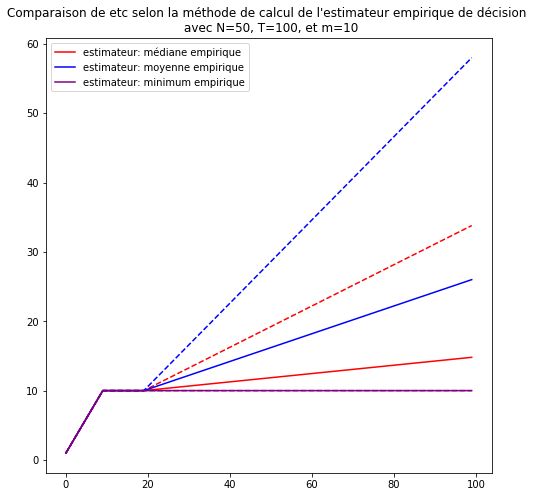

In [7]:
N,T = 50, 100

m=10

x_m=np.array([1,2])
k=np.array([1,1])

cum_regrets_etc_median = []

for i in range(N):
    banditest = ParetoBandit(x_m=x_m,k=k,seed=None)
    etc_pareto(banditest, T=T, m=m, discret=False, method='median')
    cum_regrets_etc_median.append(banditest.get_cumulative_regret())

cum_regrets_etc_median_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_median)
cum_regrets_etc_median_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_median)

plt.plot(range(T),cum_regrets_etc_median_moy,color='red',label='estimateur: médiane empirique') #affichage du graphique
plt.plot(range(T),cum_regrets_etc_median_moy + cum_regrets_etc_median_sd,color='red', linestyle='dashed')

cum_regrets_etc_moyenne = []

for i in range(N):
    banditest = ParetoBandit(x_m=x_m,k=k,seed=None)
    etc_pareto(banditest, T=T, m=m, discret=False, method='mean')
    cum_regrets_etc_moyenne.append(banditest.get_cumulative_regret())
    
cum_regrets_etc_moyenne_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_moyenne)
cum_regrets_etc_moyenne_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_moyenne)

plt.plot(range(T),cum_regrets_etc_moyenne_moy, color='blue', label='estimateur: moyenne empirique') #affichage du graphique
plt.plot(range(T),cum_regrets_etc_moyenne_moy + cum_regrets_etc_moyenne_sd, color='blue', linestyle='dashed')

cum_regrets_etc_min = []

for i in range(N):
    banditest = ParetoBandit(x_m=x_m,k=k,seed=None)
    etc_pareto(banditest, T=T, m=m, discret=False, method='min')
    cum_regrets_etc_min.append(banditest.get_cumulative_regret())
    
cum_regrets_etc_min_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_min)
cum_regrets_etc_min_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_min)

plt.plot(range(T),cum_regrets_etc_min_moy, color='purple', label='estimateur: minimum empirique') #affichage du graphique
plt.plot(range(T),cum_regrets_etc_min_moy + cum_regrets_etc_min_sd, color='purple', linestyle='dashed')

plt.title("Comparaison de etc selon la méthode de calcul de l'estimateur empirique de décision \n avec N={}, T={}, et m={}".format(N,T,m))
plt.legend()


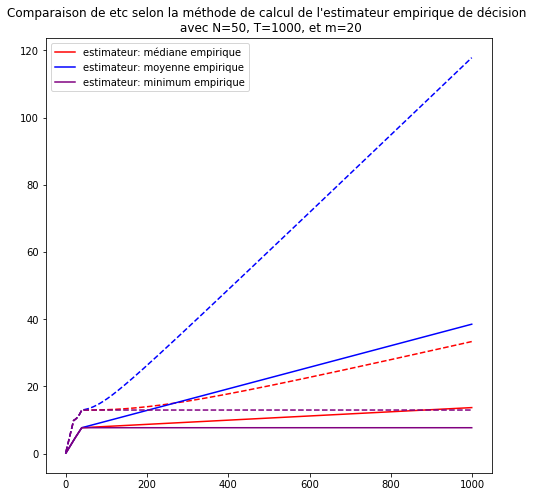

In [8]:
N,T = 50, 1000

m=20

x_m=np.random.rand(50,2)

k=np.array([1,1])


cum_regrets_etc_median = []

for i in range(N):
    banditest = ParetoBandit(x_m=x_m[i],k=k,seed=None)
    etc_pareto(banditest, T=T, m=m, discret=False, method='median')
    cum_regrets_etc_median.append(banditest.get_cumulative_regret())

cum_regrets_etc_median_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_median)
cum_regrets_etc_median_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_median)

plt.plot(range(T),cum_regrets_etc_median_moy,color='red',label='estimateur: médiane empirique') #affichage du graphique
plt.plot(range(T),cum_regrets_etc_median_moy + cum_regrets_etc_median_sd,color='red', linestyle='dashed')

cum_regrets_etc_moyenne = []

for i in range(N):
    banditest = ParetoBandit(x_m=x_m[i],k=k,seed=None)
    etc_pareto(banditest, T=T, m=m, discret=False, method='mean')
    cum_regrets_etc_moyenne.append(banditest.get_cumulative_regret())
    
cum_regrets_etc_moyenne_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_moyenne)
cum_regrets_etc_moyenne_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_moyenne)

plt.plot(range(T),cum_regrets_etc_moyenne_moy, color='blue', label='estimateur: moyenne empirique') #affichage du graphique
plt.plot(range(T),cum_regrets_etc_moyenne_moy + cum_regrets_etc_moyenne_sd, color='blue', linestyle='dashed')

cum_regrets_etc_min = []

for i in range(N):
    banditest = ParetoBandit(x_m=x_m[i],k=k,seed=None)
    etc_pareto(banditest, T=T, m=m, discret=False, method='min')
    cum_regrets_etc_min.append(banditest.get_cumulative_regret())
    
cum_regrets_etc_min_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_min)
cum_regrets_etc_min_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_min)

plt.plot(range(T),cum_regrets_etc_min_moy, color='purple', label='estimateur: minimum empirique') #affichage du graphique
plt.plot(range(T),cum_regrets_etc_min_moy + cum_regrets_etc_min_sd, color='purple', linestyle='dashed')

plt.title("Comparaison de etc selon la méthode de calcul de l'estimateur empirique de décision \n avec N={}, T={}, et m={}".format(N,T,m))
plt.legend()

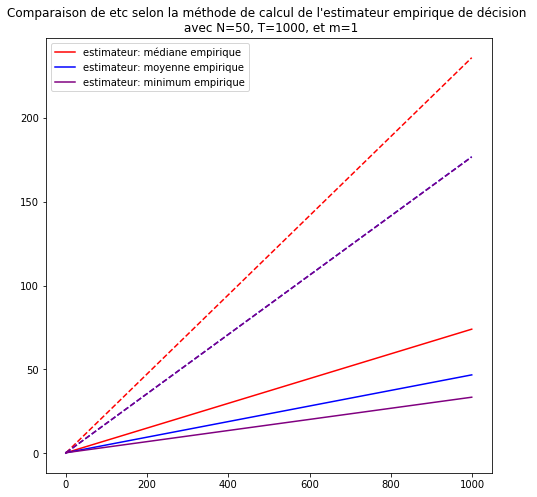

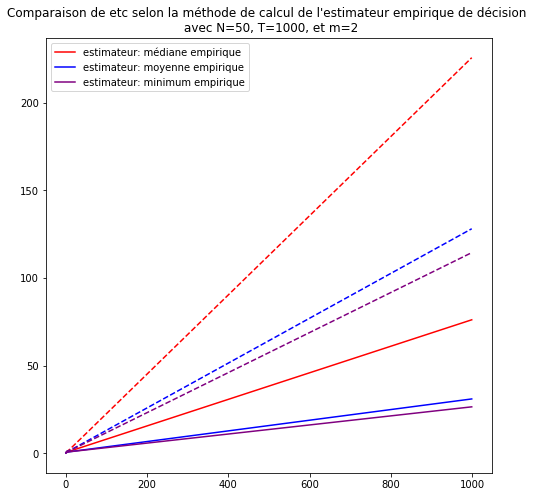

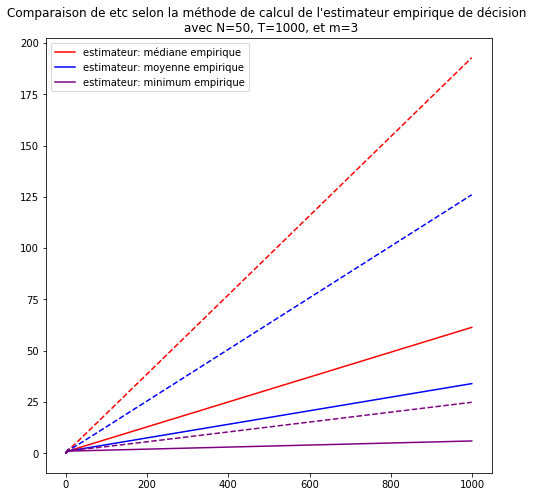

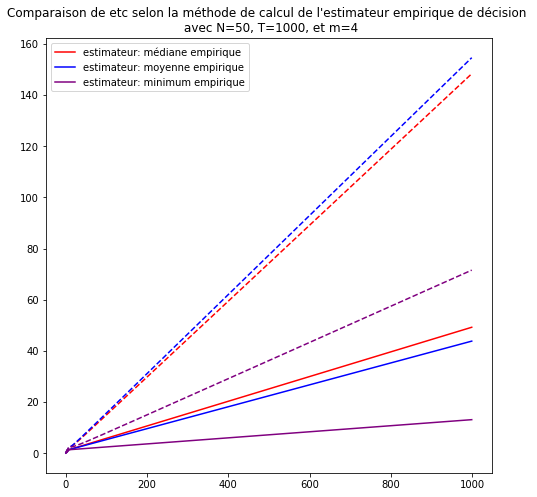

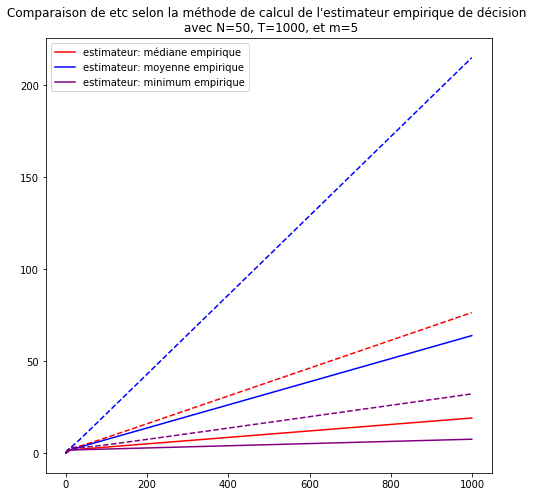

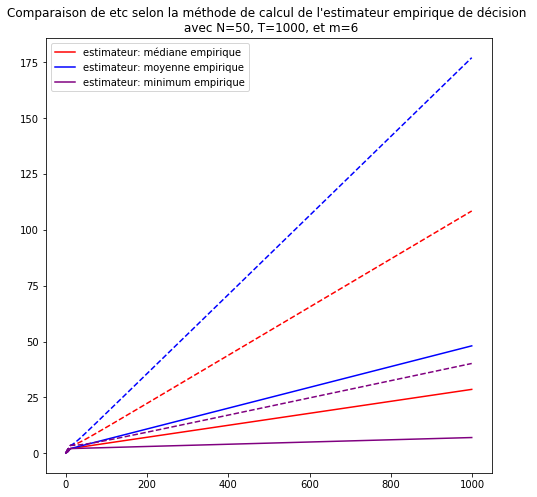

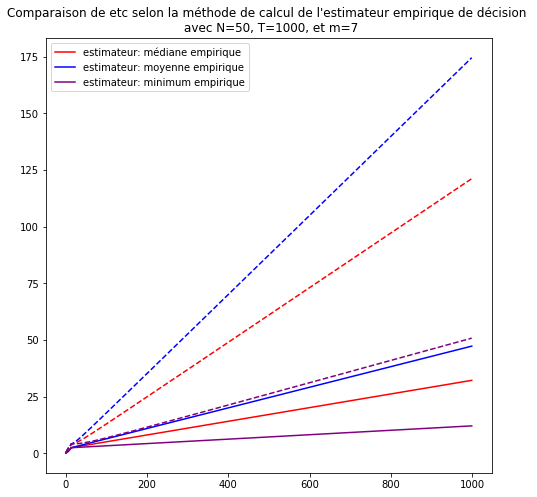

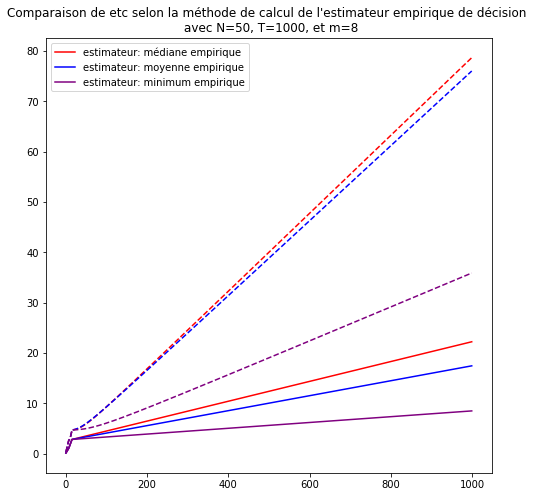

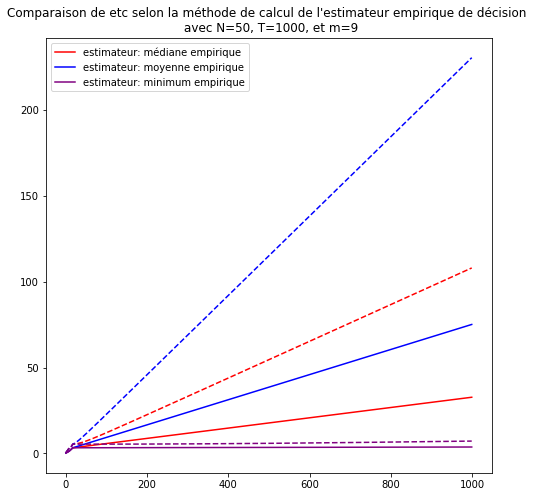

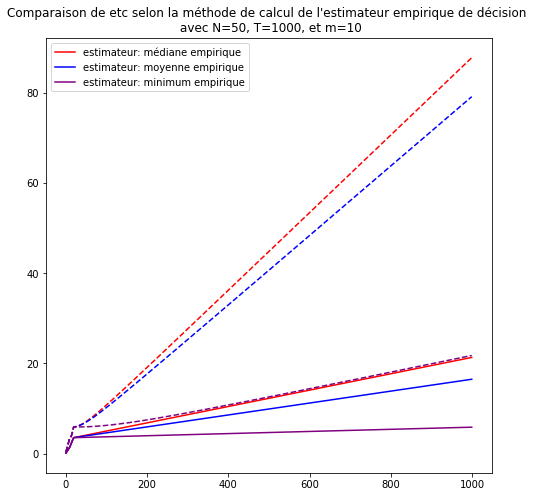

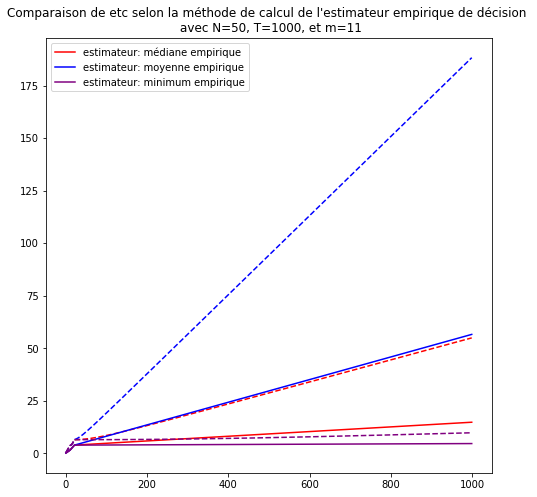

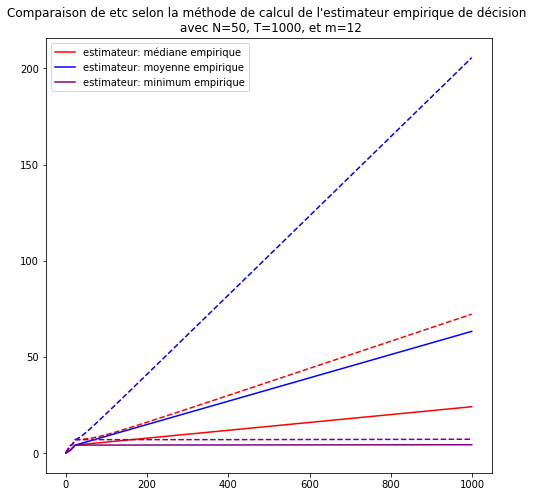

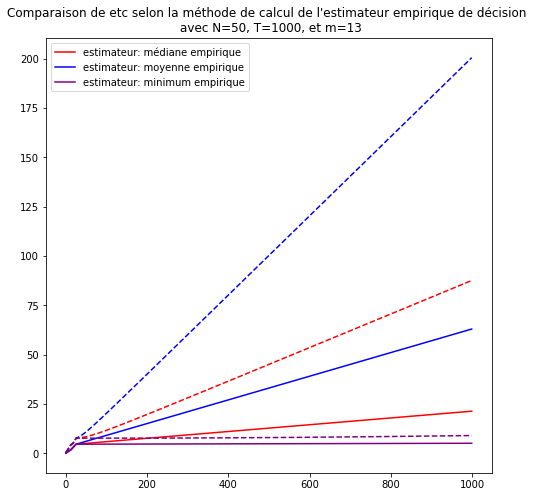

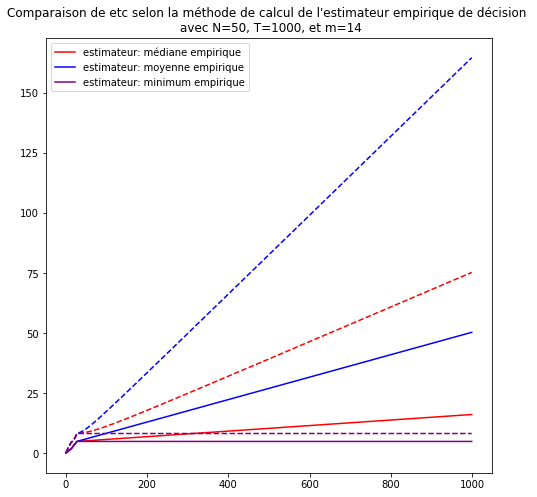

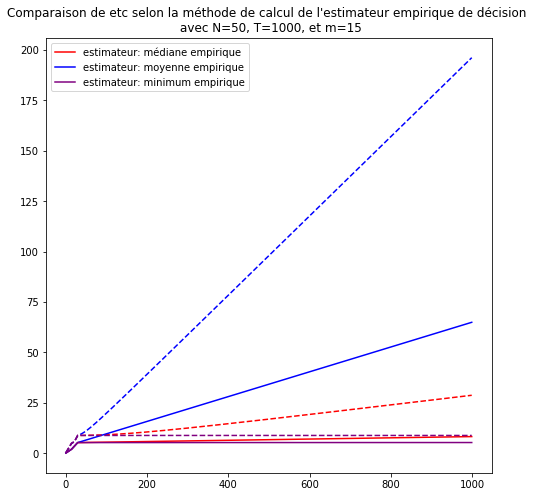

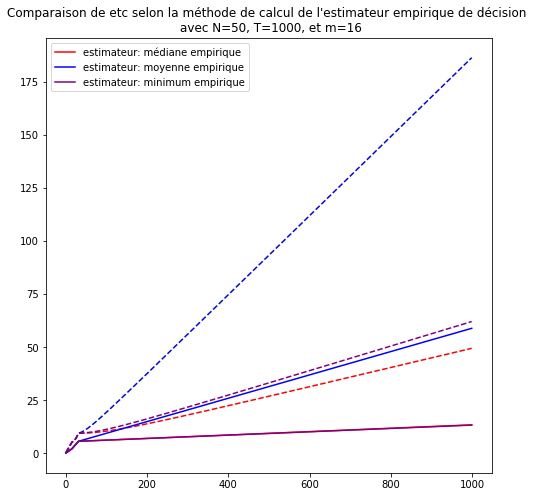

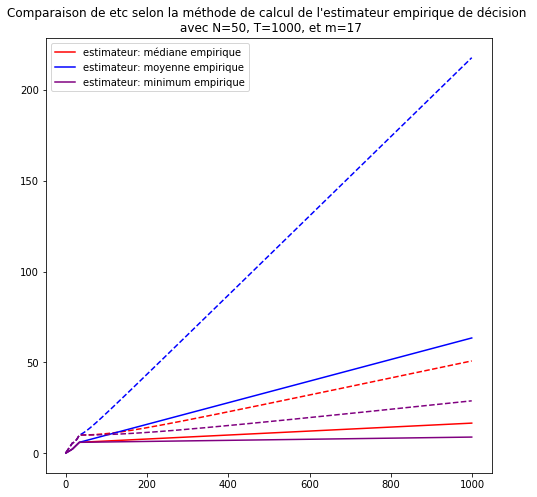

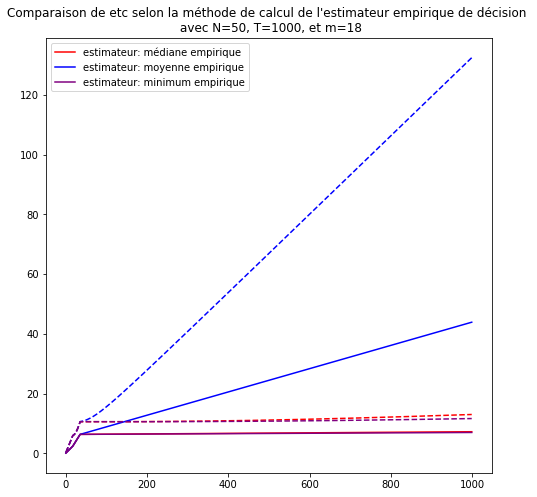

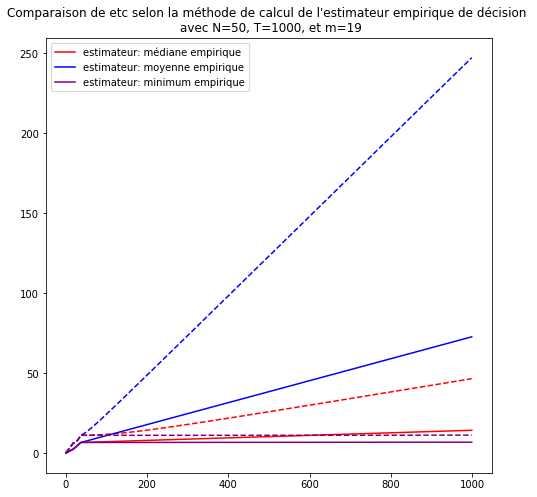

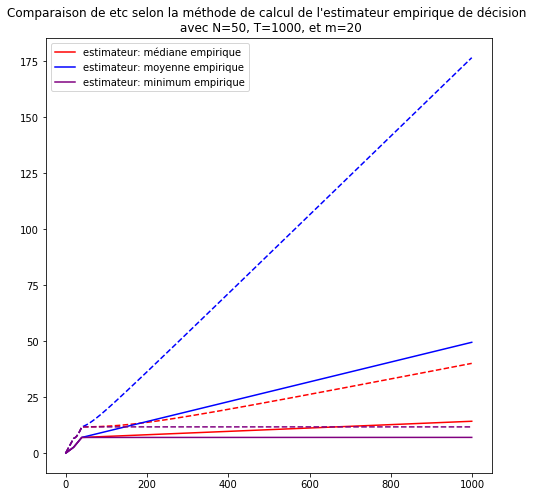

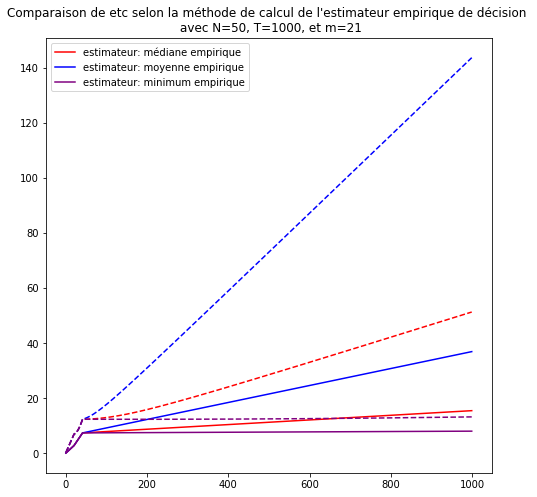

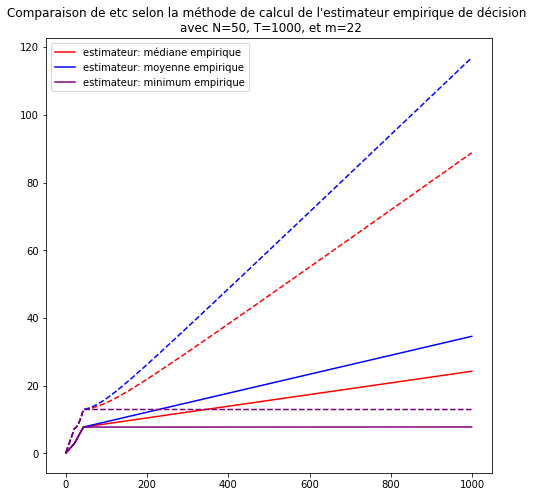

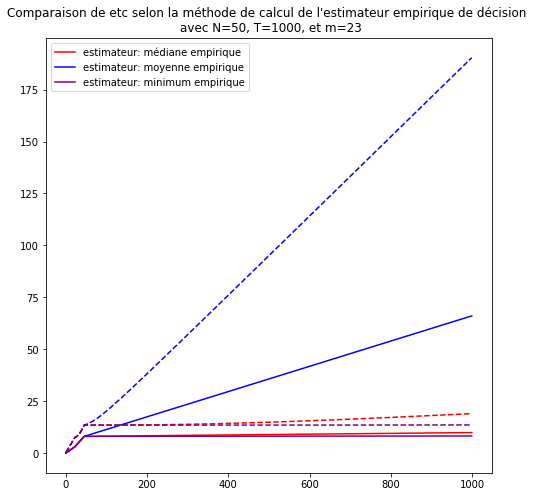

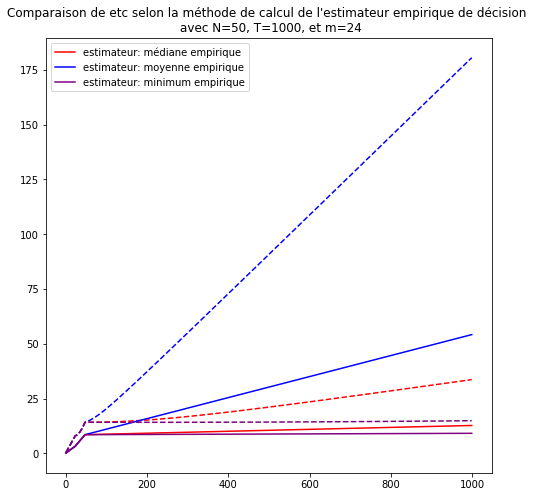

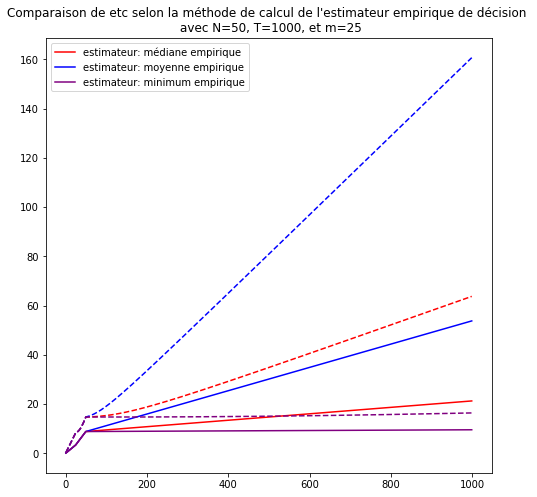

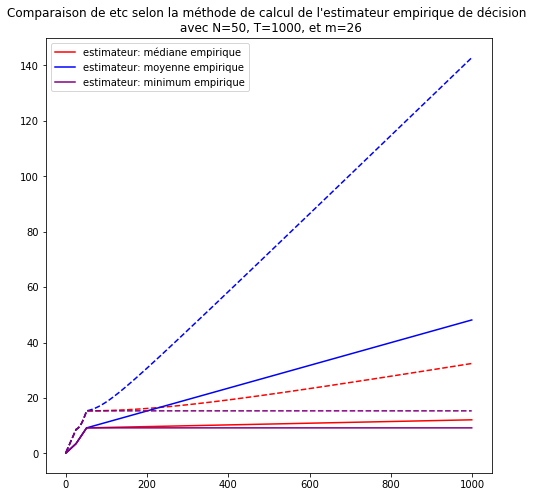

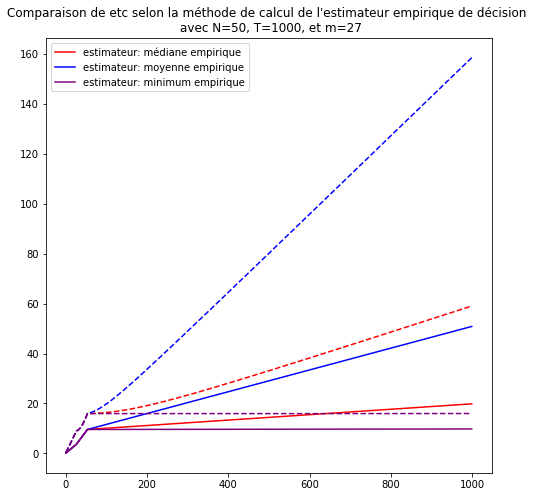

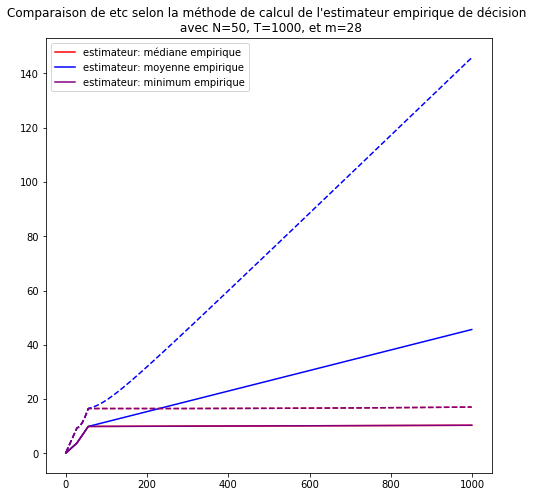

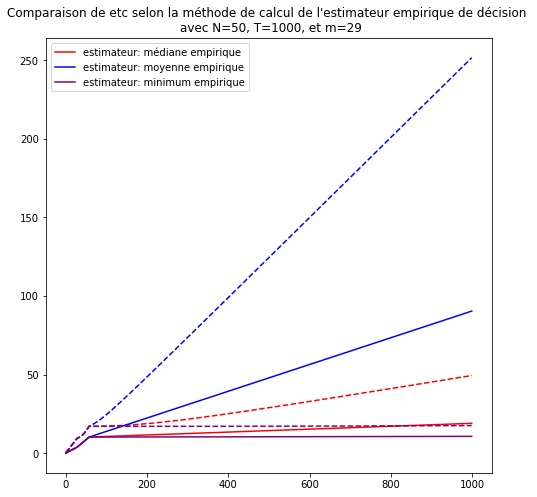

In [9]:
N,T = 50, 1000

#m=20

x_m=np.random.rand(50,2)

k=np.array([1,1])

for m in range(1,30):

    cum_regrets_etc_median = []

    for i in range(N):
        banditest = ParetoBandit(x_m=x_m[i],k=k,seed=None)
        etc_pareto(banditest, T=T, m=m, discret=False, method='median')
        cum_regrets_etc_median.append(banditest.get_cumulative_regret())

    cum_regrets_etc_median_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_median)
    cum_regrets_etc_median_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_median)

    plt.plot(range(T),cum_regrets_etc_median_moy,color='red',label='estimateur: médiane empirique') #affichage du graphique
    plt.plot(range(T),cum_regrets_etc_median_moy + cum_regrets_etc_median_sd,color='red', linestyle='dashed')

    cum_regrets_etc_moyenne = []

    for i in range(N):
        banditest = ParetoBandit(x_m=x_m[i],k=k,seed=None)
        etc_pareto(banditest, T=T, m=m, discret=False, method='mean')
        cum_regrets_etc_moyenne.append(banditest.get_cumulative_regret())
    
    cum_regrets_etc_moyenne_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_moyenne)
    cum_regrets_etc_moyenne_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_moyenne)

    plt.plot(range(T),cum_regrets_etc_moyenne_moy, color='blue', label='estimateur: moyenne empirique') #affichage du graphique
    plt.plot(range(T),cum_regrets_etc_moyenne_moy + cum_regrets_etc_moyenne_sd, color='blue', linestyle='dashed')

    cum_regrets_etc_min = []

    for i in range(N):
        banditest = ParetoBandit(x_m=x_m[i],k=k,seed=None)
        etc_pareto(banditest, T=T, m=m, discret=False, method='min')
        cum_regrets_etc_min.append(banditest.get_cumulative_regret())
    
    cum_regrets_etc_min_moy = np.apply_along_axis(np.mean, 0, cum_regrets_etc_min)
    cum_regrets_etc_min_sd = np.apply_along_axis(np.std, 0, cum_regrets_etc_min)

    plt.plot(range(T),cum_regrets_etc_min_moy, color='purple', label='estimateur: minimum empirique') #affichage du graphique
    plt.plot(range(T),cum_regrets_etc_min_moy + cum_regrets_etc_min_sd, color='purple', linestyle='dashed')

    plt.title("Comparaison de etc selon la méthode de calcul de l'estimateur empirique de décision \n avec N={}, T={}, et m={}".format(N,T,m))
    plt.legend()
    plt.show()

In [10]:
def epsilon_greedy_pareto(bandit, epsilon, T, method='mean'):
    '''Play the given bandit over T rounds and return the greedy action . '''
    
    K = bandit.get_K()  #Obtention du nombre d'actions possibles.
    r = np.zeros(T)        #Préparation du vecteur de rewards, init. 0
    
    # Préparation d'une liste de K listes prêt à contenir les rewards pour chacune des K actions.
    R = []
    for i in range(K):
        R.append([])
    
    #Préparation d'un vecteur pour l'estimateur empirique de chaque action
    #initialisée à 0. L'estimateur empirique sera la moyenne ou la médiane
    
    estimateur = np.zeros(K) 
                                        
    #Le jeu commence
    for t in range(T):
        
        kstar_est = np.where(estimateur == max(estimateur))[0]
    
        #Traitement du bris d'égalité
        if (len(kstar_est) > 1): 
            kstar_est = np.random.choice(kstar_est,1)[0]
            
        if (np.random.rand(1) < epsilon):
            #explorer, jouer une des actions au hasard.
            action_played = np.random.choice(range(K),1)[0]
            r[t]=bandit.play(action_played)
            
        else:
            #exploiter, jouer l'action estimée optimale jusqu'à présent
            if(isinstance(kstar_est,np.ndarray)):
                kstar_est=kstar_est[0]
            
            action_played = kstar_est
            
            r[t] = bandit.play(action_played)
        
        #ajout du rewards dans l'historique de l'action jouée
        
        R[action_played].append(r[t])
    
        #Modifier l'estimateur de l'action jouée
        if method == 'median':
            estimateur[action_played]=np.median(R[action_played])
        elif method == 'mean':
            estimateur[action_played]=np.mean(R[action_played])
        elif method == 'min':
            estimateur[action_played]=np.min(R[action_played])
            

Test avec epsilon greedy

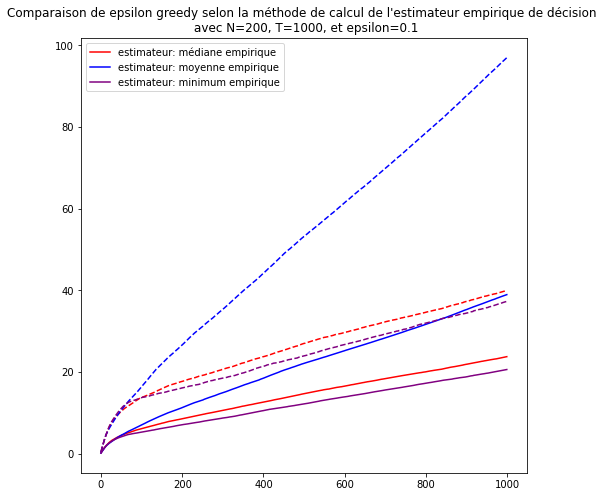

In [11]:
N,T = 200, 1000
epsilon = 0.1

x_m=np.random.rand(N,2)

k=np.array([1,1])

cum_regrets_eg_median = []

for i in range(N):
    banditest = ParetoBandit(x_m=x_m[i],k=k,seed=None)
    epsilon_greedy_pareto(banditest,epsilon, T=T, method='median')
    cum_regrets_eg_median.append(banditest.get_cumulative_regret())

cum_regrets_eg_median_moy = np.apply_along_axis(np.mean, 0, cum_regrets_eg_median)
cum_regrets_eg_median_sd = np.apply_along_axis(np.std, 0, cum_regrets_eg_median)

plt.plot(range(T),cum_regrets_eg_median_moy,color='red',label='estimateur: médiane empirique') #affichage du graphique
plt.plot(range(T),cum_regrets_eg_median_moy + cum_regrets_eg_median_sd,color='red', linestyle='dashed')

cum_regrets_eg_moyenne = []

for i in range(N):
    banditest = ParetoBandit(x_m=x_m[i],k=k,seed=None)
    epsilon_greedy_pareto(banditest, epsilon, T=T, method='mean')
    cum_regrets_eg_moyenne.append(banditest.get_cumulative_regret())
    
cum_regrets_eg_moyenne_moy = np.apply_along_axis(np.mean, 0, cum_regrets_eg_moyenne)
cum_regrets_eg_moyenne_sd = np.apply_along_axis(np.std, 0, cum_regrets_eg_moyenne)

plt.plot(range(T),cum_regrets_eg_moyenne_moy, color='blue', label='estimateur: moyenne empirique') #affichage du graphique
plt.plot(range(T),cum_regrets_eg_moyenne_moy + cum_regrets_eg_moyenne_sd, color='blue', linestyle='dashed')

cum_regrets_eg_min = []

for i in range(N):
    banditest = ParetoBandit(x_m=x_m[i],k=k,seed=None)
    epsilon_greedy_pareto(banditest, epsilon, T=T, method='min')
    cum_regrets_eg_min.append(banditest.get_cumulative_regret())
    
cum_regrets_eg_min_moy = np.apply_along_axis(np.mean, 0, cum_regrets_eg_min)
cum_regrets_eg_min_sd = np.apply_along_axis(np.std, 0, cum_regrets_eg_min)

plt.plot(range(T),cum_regrets_eg_min_moy, color='purple', label='estimateur: minimum empirique') #affichage du graphique
plt.plot(range(T),cum_regrets_eg_min_moy + cum_regrets_eg_min_sd, color='purple', linestyle='dashed')

plt.title("Comparaison de epsilon greedy selon la méthode de calcul de l'estimateur empirique de décision \n avec N={}, T={}, et epsilon={}".format(N,T,epsilon))

plt.legend()

In [12]:
# Algorithme Greedy-epsilon avec epsilon=1/sqrt(t) pour les lois de Pareto

def epsilon_greedy_rule_pareto(bandit, T, method='mean'):
    '''Play the given bandit over T rounds and return the greedy action . '''
    
    K = bandit.get_K()  #Obtention du nombre d'actions possibles.
    r = np.zeros(T)        #Préparation du vecteur de rewards, init. 0
    
    # Préparation d'une liste de K listes prêt à contenir les rewards pour chacune des K actions.
    R = []
    for i in range(K):
        R.append([])
    
    
    #Préparation d'un vecteur pour l'estimateur empirique de chaque action
    #initialisée à 0. L'estimateur empirique sera la moyenne ou la médiane
    estimateur = np.zeros(K)
    
    #Le jeu commence
    for t in range(T):
    
        epsilon = min([1,1/sqrt(t+1)]) #Ici, c'est t+1 car t commence à 0 dans Python.
            
        kstar_est = np.where(estimateur == max(estimateur))[0]
    
        #Traitement du bris d'égalité
        if (len(kstar_est) > 1): 
            kstar_est = np.random.choice(kstar_est,1)[0]
            
        if (np.random.rand(1) < epsilon):
            #explorer, jouer une des actions au hasard.
            action_played = np.random.choice(range(K),1)[0]
            r[t]=bandit.play(action_played)
            
        else:
            #exploiter, jouer l'action estimée optimale jusqu'à présent
            if(isinstance(kstar_est,np.ndarray)):
                kstar_est=kstar_est[0]
            
            action_played = kstar_est
            
            r[t] = bandit.play(action_played)
        
        #ajout du rewards dans l'historique de l'action jouée
        
        R[action_played].append(r[t])
    
        if method == 'median':
            estimateur[action_played]=np.median(R[action_played])
        elif method == 'mean':
            estimateur[action_played]=np.mean(R[action_played])
        elif method == 'min':
            estimateur[action_played]=np.min(R[action_played])
            

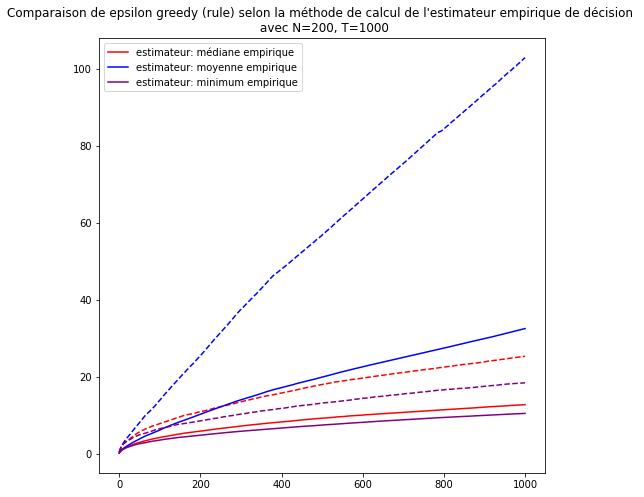

In [13]:
N,T = 200, 1000

x_m=np.random.rand(N,2)

k=np.array([1,1])

cum_regrets_egr_median = []

for i in range(N):
    banditest = ParetoBandit(x_m=x_m[i],k=k,seed=None)
    epsilon_greedy_rule_pareto(banditest, T=T, method='median')
    cum_regrets_egr_median.append(banditest.get_cumulative_regret())

cum_regrets_egr_median_moy = np.apply_along_axis(np.mean, 0, cum_regrets_egr_median)
cum_regrets_egr_median_sd = np.apply_along_axis(np.std, 0, cum_regrets_egr_median)

plt.plot(range(T),cum_regrets_egr_median_moy,color='red',label='estimateur: médiane empirique') #affichage du graphique
plt.plot(range(T),cum_regrets_egr_median_moy + cum_regrets_egr_median_sd,color='red', linestyle='dashed')

cum_regrets_egr_moyenne = []

for i in range(N):
    banditest = ParetoBandit(x_m=x_m[i],k=k,seed=None)
    epsilon_greedy_rule_pareto(banditest, T=T, method='mean')
    cum_regrets_egr_moyenne.append(banditest.get_cumulative_regret())
    
cum_regrets_egr_moyenne_moy = np.apply_along_axis(np.mean, 0, cum_regrets_egr_moyenne)
cum_regrets_egr_moyenne_sd = np.apply_along_axis(np.std, 0, cum_regrets_egr_moyenne)

plt.plot(range(T),cum_regrets_egr_moyenne_moy, color='blue', label='estimateur: moyenne empirique') #affichage du graphique
plt.plot(range(T),cum_regrets_egr_moyenne_moy + cum_regrets_egr_moyenne_sd, color='blue', linestyle='dashed')

cum_regrets_egr_min = []

for i in range(N):
    banditest = ParetoBandit(x_m=x_m[i],k=k,seed=None)
    epsilon_greedy_rule_pareto(banditest, T=T, method='min')
    cum_regrets_egr_min.append(banditest.get_cumulative_regret())
    
cum_regrets_egr_min_moy = np.apply_along_axis(np.mean, 0, cum_regrets_egr_min)
cum_regrets_egr_min_sd = np.apply_along_axis(np.std, 0, cum_regrets_egr_min)

plt.plot(range(T),cum_regrets_egr_min_moy, color='purple', label='estimateur: minimum empirique') #affichage du graphique
plt.plot(range(T),cum_regrets_egr_min_moy + cum_regrets_egr_min_sd, color='purple', linestyle='dashed')

plt.title("Comparaison de epsilon greedy (rule) selon la méthode de calcul de l'estimateur empirique de décision \n avec N={}, T={}".format(N,T))

plt.legend()